In [76]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats.mstats import trimboth
from sklearn.cluster import KMeans
from sklearn.preprocessing import OneHotEncoder, StandardScaler
import hyperopt
from hyperopt import hp, fmin, tpe, STATUS_OK, Trials
from hyperopt.pyll import scope
from sklearn.ensemble import IsolationForest
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import SelectKBest, f_regression
from sklearn.model_selection import cross_val_score, train_test_split
from sklearn.metrics import make_scorer, mean_absolute_error
import lightgbm as lgb
import copy
import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
df = pd.read_csv('CL_megafon_Cup IT_2020_final_data.csv', sep=';')

In [4]:
df.head()

,time_start,time_end,place_latitude,place_longitude
0,2019-08-24 14:23:56,2019-08-24 18:54:47,28.102908,113.617867
1,2018-06-19 08:56:22,2018-06-19 12:15:26,28.102908,113.617867
2,2018-08-29 14:00:32,2018-08-29 14:37:51,28.102908,113.617867
3,2019-12-10 16:01:26,2019-12-10 16:35:22,28.102908,113.617867
4,2019-12-10 13:39:42,2019-12-10 17:58:22,28.999495,115.167583


In [5]:
dates = pd.read_csv('Dates.csv', sep=';')

In [6]:
dates.head()

,Date,Weekday,half_holiday,Holiday,Holiday_weekends,Regular_weekends,All_weekends,Year,Month,number_in_Year,number_in_Month,Season
0,2018-01-01,Monday,0,1,1,0,1,2018,1,1,1,Winter
1,2018-01-02,Tuesday,0,0,1,0,1,2018,1,2,2,Winter
2,2018-01-03,Wednesday,0,0,1,0,1,2018,1,3,3,Winter
3,2018-01-04,Thursday,0,0,1,0,1,2018,1,4,4,Winter
4,2018-01-05,Friday,0,0,1,0,1,2018,1,5,5,Winter


In [7]:
df['time_start'] = pd.to_datetime(df['time_start'], yearfirst=True)
df['time_end'] = pd.to_datetime(df['time_end'], yearfirst=True)

In [9]:
df.sort_values(by='time_start', ascending=True, inplace=True)

In [10]:
df['delta'] = (df['time_end'] - df['time_start']).dt.seconds / 60

In [11]:
tt = df['delta'].iloc[0]

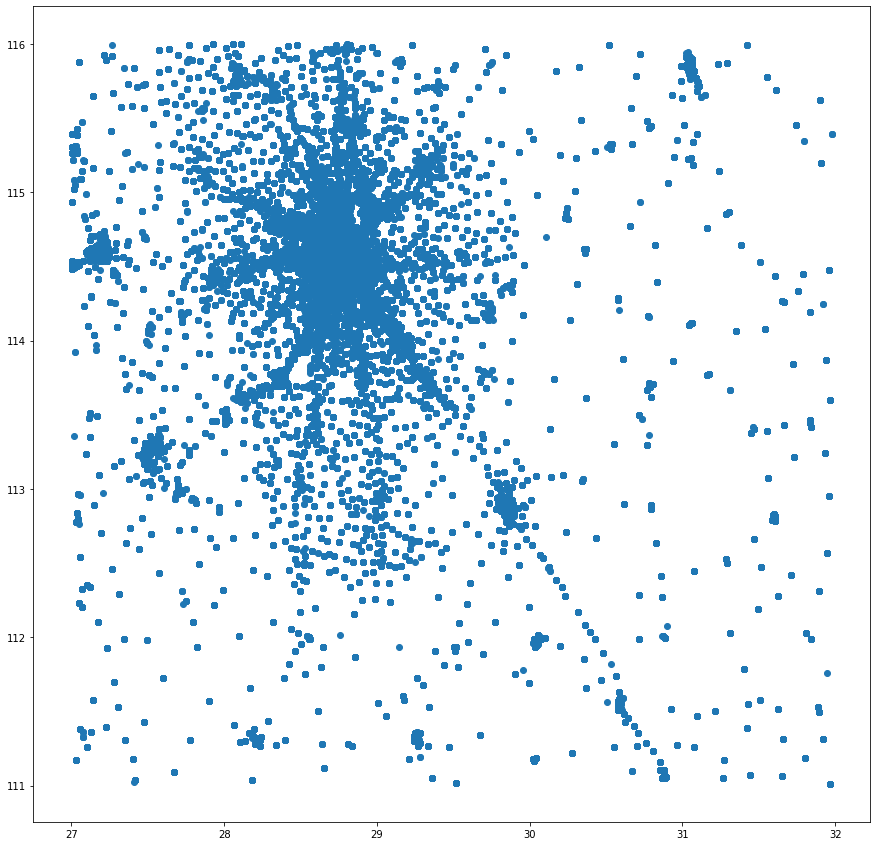

In [12]:
plt.figure(figsize=(15, 15))
plt.scatter(df['place_latitude'], df['place_longitude'])

In [14]:
km = KMeans(n_clusters=20)

In [15]:
km.fit(df[['place_latitude', 'place_longitude']])

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
    n_clusters=20, n_init=10, n_jobs=None, precompute_distances='auto',
    random_state=None, tol=0.0001, verbose=0)

In [16]:
preds = km.predict(df[['place_latitude', 'place_longitude']])

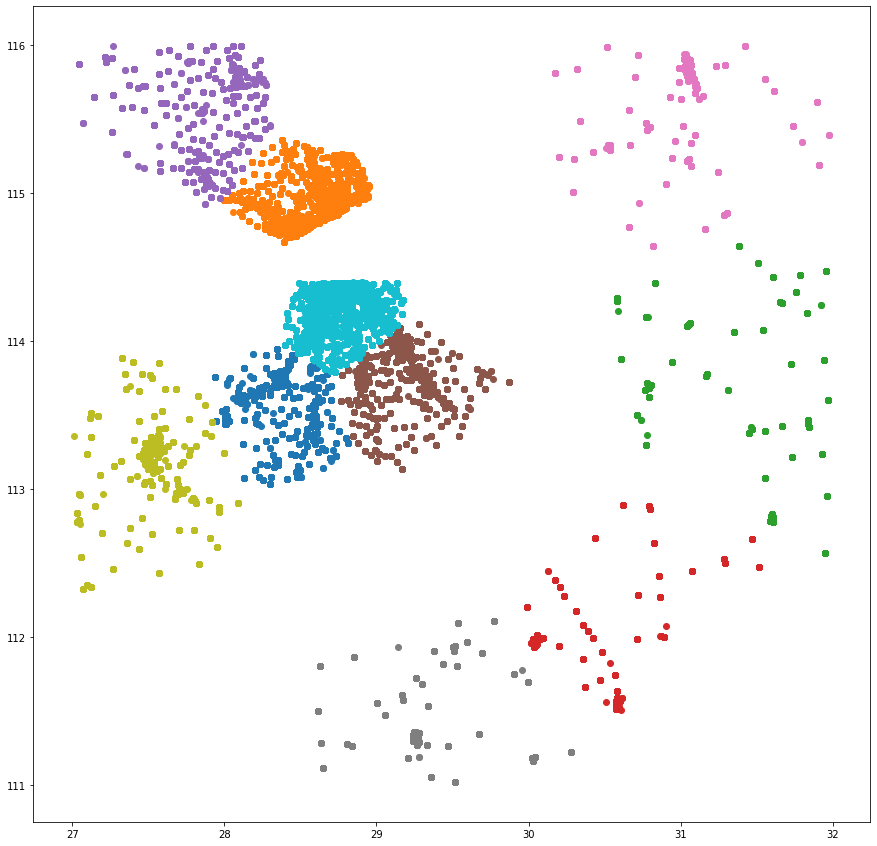

In [17]:
plt.figure(figsize=(15, 15))
for i in range(10):
    df_plot = df[preds == i]
    plt.scatter(df_plot['place_latitude'], df_plot['place_longitude'])

In [18]:
df['geo_cluster'] = preds

In [19]:
df.head()

,time_start,time_end,place_latitude,place_longitude,delta,geo_cluster
73313,2018-01-01 04:35:56,2018-01-01 12:28:19,28.227964,113.565739,472.383333,0
17836,2018-01-01 09:30:40,2018-01-01 10:37:56,28.871813,114.592832,67.266667,14
5389,2018-01-01 09:57:24,2018-01-01 10:16:29,28.844192,114.560353,19.083333,14
53801,2018-01-01 10:06:01,2018-01-01 12:50:29,28.768786,114.582630,164.466667,14
56346,2018-01-01 11:07:07,2018-04-13 14:18:41,28.650852,114.595380,191.566667,14


In [20]:
st = df['time_start']

(array([1.000e+00, 1.000e+00, 1.000e+00, 0.000e+00, 3.000e+00, 0.000e+00,
        3.000e+00, 4.000e+00, 1.000e+00, 3.000e+00, 8.000e+00, 2.100e+01,
        1.400e+01, 1.500e+01, 1.800e+01, 2.000e+01, 1.400e+01, 1.600e+01,
        1.600e+01, 2.500e+01, 4.600e+01, 6.800e+01, 6.500e+01, 3.560e+02,
        7.520e+02, 3.950e+03, 6.502e+03, 6.603e+03, 7.523e+03, 7.676e+03,
        7.353e+03, 7.020e+03, 6.183e+03, 5.448e+03, 4.958e+03, 4.017e+03,
        2.840e+03, 2.251e+03, 2.161e+03, 2.267e+03]),
 array([-3.40119738, -3.13436038, -2.86752338, -2.60068638, -2.33384938,
        -2.06701238, -1.80017538, -1.53333838, -1.26650138, -0.99966438,
        -0.73282737, -0.46599037, -0.19915337,  0.06768363,  0.33452063,
         0.60135763,  0.86819463,  1.13503163,  1.40186863,  1.66870563,
         1.93554263,  2.20237963,  2.46921663,  2.73605363,  3.00289063,
         3.26972764,  3.53656464,  3.80340164,  4.07023864,  4.33707564,
         4.60391264,  4.87074964,  5.13758664,  5.40442364,  5.6

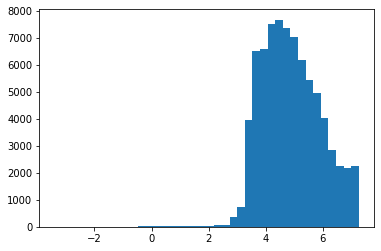

In [21]:
plt.hist(np.log(df['delta']), bins=40)

In [22]:
df['date_start'] = df['time_start'].dt.date

In [23]:
dates['Date'] = pd.to_datetime(dates['Date'])

In [24]:
df['date_start'] = pd.to_datetime(df['date_start'])

In [25]:
df_joined = pd.merge(df, dates, how='left', left_on='date_start', right_on='Date')

In [26]:
df_joined.head()

,time_start,time_end,place_latitude,place_longitude,delta,geo_cluster,date_start,Date,Weekday,half_holiday,Holiday,Holiday_weekends,Regular_weekends,All_weekends,Year,Month,number_in_Year,number_in_Month,Season
0,2018-01-01 04:35:56,2018-01-01 12:28:19,28.227964,113.565739,472.383333,0,2018-01-01,2018-01-01,Monday,0,1,1,0,1,2018,1,1,1,Winter
1,2018-01-01 09:30:40,2018-01-01 10:37:56,28.871813,114.592832,67.266667,14,2018-01-01,2018-01-01,Monday,0,1,1,0,1,2018,1,1,1,Winter
2,2018-01-01 09:57:24,2018-01-01 10:16:29,28.844192,114.560353,19.083333,14,2018-01-01,2018-01-01,Monday,0,1,1,0,1,2018,1,1,1,Winter
3,2018-01-01 10:06:01,2018-01-01 12:50:29,28.768786,114.582630,164.466667,14,2018-01-01,2018-01-01,Monday,0,1,1,0,1,2018,1,1,1,Winter
4,2018-01-01 11:07:07,2018-04-13 14:18:41,28.650852,114.595380,191.566667,14,2018-01-01,2018-01-01,Monday,0,1,1,0,1,2018,1,1,1,Winter


In [27]:
df = df_joined.copy()

In [28]:
df.head()

,time_start,time_end,place_latitude,place_longitude,delta,geo_cluster,date_start,Date,Weekday,half_holiday,Holiday,Holiday_weekends,Regular_weekends,All_weekends,Year,Month,number_in_Year,number_in_Month,Season
0,2018-01-01 04:35:56,2018-01-01 12:28:19,28.227964,113.565739,472.383333,0,2018-01-01,2018-01-01,Monday,0,1,1,0,1,2018,1,1,1,Winter
1,2018-01-01 09:30:40,2018-01-01 10:37:56,28.871813,114.592832,67.266667,14,2018-01-01,2018-01-01,Monday,0,1,1,0,1,2018,1,1,1,Winter
2,2018-01-01 09:57:24,2018-01-01 10:16:29,28.844192,114.560353,19.083333,14,2018-01-01,2018-01-01,Monday,0,1,1,0,1,2018,1,1,1,Winter
3,2018-01-01 10:06:01,2018-01-01 12:50:29,28.768786,114.582630,164.466667,14,2018-01-01,2018-01-01,Monday,0,1,1,0,1,2018,1,1,1,Winter
4,2018-01-01 11:07:07,2018-04-13 14:18:41,28.650852,114.595380,191.566667,14,2018-01-01,2018-01-01,Monday,0,1,1,0,1,2018,1,1,1,Winter


In [29]:
ts = df['time_start']

In [30]:
df['hour'] = df['time_start'].dt.hour
#df['day'] = df['time_start'].dt.day
df['Weekday'] = df['time_start'].dt.dayofweek
#df['month'] = df['time_start'].dt.month
#df['year'] = df['time_start'].dt.year

In [31]:
df.head()

,time_start,time_end,place_latitude,place_longitude,delta,geo_cluster,date_start,Date,Weekday,half_holiday,Holiday,Holiday_weekends,Regular_weekends,All_weekends,Year,Month,number_in_Year,number_in_Month,Season,hour
0,2018-01-01 04:35:56,2018-01-01 12:28:19,28.227964,113.565739,472.383333,0,2018-01-01,2018-01-01,0,0,1,1,0,1,2018,1,1,1,Winter,4
1,2018-01-01 09:30:40,2018-01-01 10:37:56,28.871813,114.592832,67.266667,14,2018-01-01,2018-01-01,0,0,1,1,0,1,2018,1,1,1,Winter,9
2,2018-01-01 09:57:24,2018-01-01 10:16:29,28.844192,114.560353,19.083333,14,2018-01-01,2018-01-01,0,0,1,1,0,1,2018,1,1,1,Winter,9
3,2018-01-01 10:06:01,2018-01-01 12:50:29,28.768786,114.582630,164.466667,14,2018-01-01,2018-01-01,0,0,1,1,0,1,2018,1,1,1,Winter,10
4,2018-01-01 11:07:07,2018-04-13 14:18:41,28.650852,114.595380,191.566667,14,2018-01-01,2018-01-01,0,0,1,1,0,1,2018,1,1,1,Winter,11


In [32]:
df['log_target'] = np.log(df['delta'])
mask = trimboth(df['log_target'], 0.025).mask
df = df[mask == False]

In [33]:
oh_season = OneHotEncoder(sparse=False)

In [34]:
encoded_seasons = oh_season.fit_transform(df['Season'].values.reshape(-1, 1))

In [35]:
oh_weekday = OneHotEncoder(sparse=False)

In [36]:
encoded_weekdays = oh_weekday.fit_transform(df['Weekday'].values.reshape(-1, 1))

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:363: FutureWarning: The handling of integer data will change in version 0.22. Currently, the categories are determined based on the range [0, max(values)], while in the future they will be determined based on the unique values.
If you want the future behaviour and silence this warning, you can specify "categories='auto'".
In case you used a LabelEncoder before this OneHotEncoder to convert the categories to integers, then you can now use the OneHotEncoder directly.
  warnings.warn(msg, FutureWarning)


In [37]:
df.head()

,time_start,time_end,place_latitude,place_longitude,delta,geo_cluster,date_start,Date,Weekday,half_holiday,...,Holiday_weekends,Regular_weekends,All_weekends,Year,Month,number_in_Year,number_in_Month,Season,hour,log_target
0,2018-01-01 04:35:56,2018-01-01 12:28:19,28.227964,113.565739,472.383333,0,2018-01-01,2018-01-01,0,0,...,1,0,1,2018,1,1,1,Winter,4,6.157791
1,2018-01-01 09:30:40,2018-01-01 10:37:56,28.871813,114.592832,67.266667,14,2018-01-01,2018-01-01,0,0,...,1,0,1,2018,1,1,1,Winter,9,4.208665
3,2018-01-01 10:06:01,2018-01-01 12:50:29,28.768786,114.582630,164.466667,14,2018-01-01,2018-01-01,0,0,...,1,0,1,2018,1,1,1,Winter,10,5.102708
4,2018-01-01 11:07:07,2018-04-13 14:18:41,28.650852,114.595380,191.566667,14,2018-01-01,2018-01-01,0,0,...,1,0,1,2018,1,1,1,Winter,11,5.255236
5,2018-01-01 13:12:26,2018-01-01 14:11:56,28.210833,113.281111,59.500000,0,2018-01-01,2018-01-01,0,0,...,1,0,1,2018,1,1,1,Winter,13,4.085976


In [38]:
for i in df.columns:
    print(i)

time_start
time_end
place_latitude
place_longitude
delta
geo_cluster
date_start
Date
Weekday
half_holiday
Holiday
Holiday_weekends
Regular_weekends
All_weekends
Year
Month
number_in_Year
number_in_Month
Season
hour
log_target


In [39]:
oh_geo = OneHotEncoder(sparse=False)
encoded_geo = oh_geo.fit_transform(df['geo_cluster'].values.reshape(-1, 1))

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:363: FutureWarning: The handling of integer data will change in version 0.22. Currently, the categories are determined based on the range [0, max(values)], while in the future they will be determined based on the unique values.
If you want the future behaviour and silence this warning, you can specify "categories='auto'".
In case you used a LabelEncoder before this OneHotEncoder to convert the categories to integers, then you can now use the OneHotEncoder directly.
  warnings.warn(msg, FutureWarning)


In [40]:
X = df[['place_latitude', 'place_longitude', 'Weekday', 'half_holiday', 'Holiday', 'Holiday_weekends',
       'Regular_weekends', 'All_weekends', 'Year', 'Month', 'number_in_Year', 'number_in_Month', 'hour']]
y = df['log_target']

In [41]:
X.head()

,place_latitude,place_longitude,Weekday,half_holiday,Holiday,Holiday_weekends,Regular_weekends,All_weekends,Year,Month,number_in_Year,number_in_Month,hour
0,28.227964,113.565739,0,0,1,1,0,1,2018,1,1,1,4
1,28.871813,114.592832,0,0,1,1,0,1,2018,1,1,1,9
3,28.768786,114.582630,0,0,1,1,0,1,2018,1,1,1,10
4,28.650852,114.595380,0,0,1,1,0,1,2018,1,1,1,11
5,28.210833,113.281111,0,0,1,1,0,1,2018,1,1,1,13


In [42]:
X.values

array([[ 28.22796389, 113.56573889,   0.        , ...,   1.        ,
          1.        ,   4.        ],
       [ 28.87181328, 114.59283171,   0.        , ...,   1.        ,
          1.        ,   9.        ],
       [ 28.76878601, 114.58262955,   0.        , ...,   1.        ,
          1.        ,  10.        ],
       ...,
       [ 28.12      , 113.63888889,   4.        , ...,  31.        ,
         31.        ,  20.        ],
       [ 28.03505274, 114.59841649,   4.        , ...,  31.        ,
         31.        ,  20.        ],
       [ 28.80557753, 114.55040257,   4.        , ...,  31.        ,
         31.        ,  21.        ]])

In [43]:
sh = np.concatenate((X.values, encoded_geo, encoded_seasons, encoded_weekdays), axis=1)

In [44]:
scaler = StandardScaler()
X_tr = scaler.fit_transform(sh)

In [46]:
X_tr.shape

(74313, 44)

In [48]:
import lightgbm as lgb

In [50]:
model = lgb.LGBMRegressor(objective='mape', max_depth=7, silent=False)

In [52]:
model.fit(X_tr[:60000], y.values[:60000])

LGBMRegressor(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
       importance_type='split', learning_rate=0.1, max_depth=7,
       min_child_samples=20, min_child_weight=0.001, min_split_gain=0.0,
       n_estimators=100, n_jobs=-1, num_leaves=31, objective='mape',
       random_state=None, reg_alpha=0.0, reg_lambda=0.0, silent=False,
       subsample=1.0, subsample_for_bin=200000, subsample_freq=0)

In [55]:
preds = model.predict(X_tr[:60000])

In [56]:
def MAPE(y_true, y_pred):
    error = np.abs((y_true - y_pred) / (y_true + 0.001))
    return np.mean(error) * 100

In [65]:
MAPE(np.exp(y.values[:60000]), np.exp(preds))

64.69145956205115

In [58]:
preds_test = model.predict(X_tr[60000:])

In [66]:
MAPE(np.exp(y.values[60000:]), np.exp(preds_test))

68.26666001845975

In [70]:
y.iloc[1]

4.208664819251399

In [71]:
N_TIME_STEPS = 20
N_FEATURES = X_tr.shape[1]
segments = []
targets = []
for i in range(N_TIME_STEPS, X_tr.shape[0], 1):
    segment = X_tr[i-N_TIME_STEPS:i, :]
    target = y.iloc[i]
    segments.append(segment)
    targets.append(target)

In [73]:
X_rn = np.asarray(segments)
y_rn = np.asarray(targets)

In [75]:
y_rn.shape

(74293,)

In [83]:
# Пространство перебора гиперпараметров для hyperopt

space ={
        'boosting_type': hp.choice( 'boosting_type', ['gbdt', 'dart'] ),
        'objective': 'mape',
        'max_depth': scope.int(hp.quniform("max_depth", 3, 12, 1)),
        'n_estimators': scope.int(hp.quniform('n_estimators', 10, 1000, 10)),
        'num_leaves': scope.int(hp.quniform ('num_leaves', 10, 500, 1)),
        'min_data_in_leaf':  scope.int(hp.quniform ('min_data_in_leaf', 10, 500, 1)),
        'feature_fraction': hp.uniform('feature_fraction', 0.5, 1.0),
        'bagging_fraction': hp.uniform('bagging_fraction', 0.5, 1.0),
        'learning_rate': hp.uniform('learning_rate', 0.001, 0.5),
        'min_sum_hessian_in_leaf': hp.uniform('min_sum_hessian_in_leaf', 0, 5),
        'lambda_l1': hp.uniform('lambda_l1', 1e-6, 1e-1 ),
        'lambda_l2': hp.uniform('lambda_l2', 1e-6, 1e-1 ),
        'seed': 42
       }

In [84]:
def objective(space):
    clf = lgb.LGBMRegressor(**space)
    clf.fit(X_tr[:60000], y.values[:60000])
    preds_test = clf.predict(X_tr[60000:])
    current_score = MAPE(np.exp(y.values[60000:]), np.exp(preds_test))
    return current_score

In [85]:
best = fmin(fn=objective, space=space, algo=tpe.suggest, max_evals=50)

100%|█████████████████████████████████████████████████| 50/50 [07:00<00:00,  8.41s/trial, best loss: 55.44902672602549]


In [86]:
params = copy.deepcopy(best)

def params_check(params):
    if params['boosting_type'] == 0:
        params['boosting_type'] = 'gbdt'
    elif params['boosting_type'] == 1:
        params['boosting_type'] = 'dart'
    
    params['max_depth'] = int(params['max_depth'])
    params['min_data_in_leaf'] = int(params['min_data_in_leaf'])
    params['n_estimators'] = int(params['n_estimators'])
    params['num_leaves'] = int(params['num_leaves'])
    params['objective'] = 'mape'
    params['seed'] = 42
    return params

In [87]:
params = params_check(params)

In [89]:
clf = lgb.LGBMRegressor(**params)
clf.fit(X_tr[:60000], y.values[:60000])
preds_test = clf.predict(X_tr[60000:])
print(MAPE(np.exp(y.values[60000:]), np.exp(preds_test)))

55.44902672602549
